In [21]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import os
from sklearn.ensemble import RandomForestClassifier



In [14]:
#Step1 Load the dataset

# Path to the directory containing the 1802 CSV files
directory_path = './data/features/'  
valence_df = pd.read_csv('./data/annotations/valence.csv')
arousal_df = pd.read_csv('./data/annotations/arousal.csv')

# List to store the loaded feature data
all_features = []

# Load each CSV file from the directory
for filename in os.listdir(directory_path):
    if filename.endswith(".csv"):
        file_path = os.path.join(directory_path, filename)
        try:
            # Load the CSV file into a DataFrame
            features = pd.read_csv(file_path, delimiter=';')
            all_features.append(features)
        except Exception as e:
            print(f"Error loading {filename}: {e}")

# Combine all the loaded features into one DataFrame
if all_features:
    features_combined = pd.concat(all_features, ignore_index=True)
else:
    print("No valid features loaded.")

In [18]:
# 2. Interpolate valence and arousal to match frameTime in features
frame_times = features_combined['frameTime']
valence_times = np.array([int(col.replace('sample_', '').replace('ms', '')) for col in valence_df.columns if 'sample' in col])
arousal_times = np.array([int(col.replace('sample_', '').replace('ms', '')) for col in arousal_df.columns if 'sample' in col])

valence_interpolated = np.interp(frame_times * 1000, valence_times, valence_df.iloc[0, 1:].values)
arousal_interpolated = np.interp(frame_times * 1000, arousal_times, arousal_df.iloc[0, 1:].values)

features_combined['valence'] = valence_interpolated
features_combined['arousal'] = arousal_interpolated

# 3. Create binary labels (1 = happy, 0 = sad)
features_combined['label'] = features_combined.apply(lambda row: 1 if row['valence'] > 0.5 and row['arousal'] > 0.5 else 0, axis=1)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


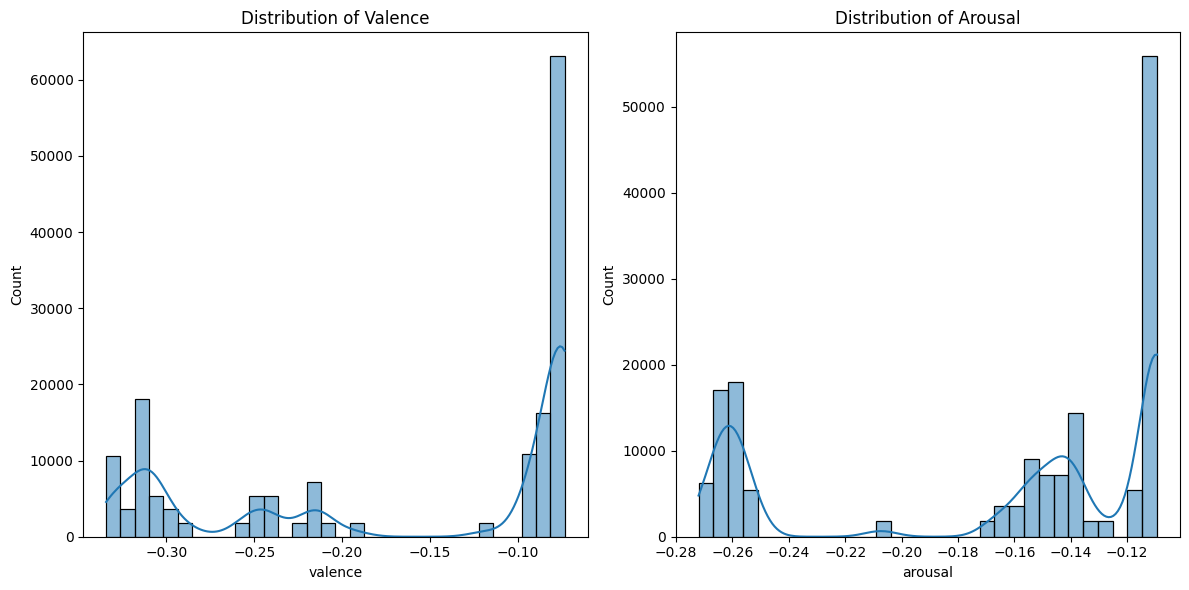

,valence,arousal
count,160192.000000,160192.000000
mean,-0.166062,-0.166920
std,0.105303,0.063396
min,-0.334287,-0.272033
25%,-0.296910,-0.256467
50%,-0.089806,-0.141597
75%,-0.073341,-0.109386
max,-0.073341,-0.109386


In [19]:
#nEDA
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Basic statistics for valence and arousal
basic_stats = features_combined[['valence', 'arousal']].describe()

# Step 2: Plot distribution of valence and arousal
plt.figure(figsize=(12, 6))

# Valence distribution
plt.subplot(1, 2, 1)
sns.histplot(features_combined['valence'], kde=True)
plt.title('Distribution of Valence')

# Arousal distribution
plt.subplot(1, 2, 2)
sns.histplot(features_combined['arousal'], kde=True)
plt.title('Distribution of Arousal')

plt.tight_layout()
plt.show()

# Display basic statistics for valence and arousal
basic_stats


label
0    457622
Name: count, dtype: int64
Accuracy: 1.0
Confusion Matrix: 
[[91525]]


/Users/abhisekjha/jupyter_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


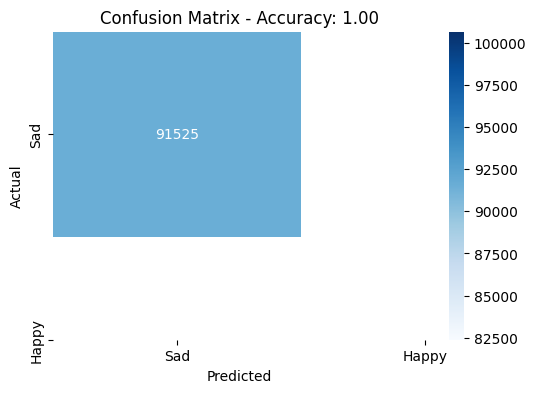

In [23]:
# Create Binary Labels
# 3. Create binary labels
features_combined['label'] = features_combined.apply(lambda row: 1 if row['valence'] > 0.5 and row['arousal'] > 0.5 else 0, axis=1)
print(features_combined['label'].value_counts())

# 4. Train a Random Forest Classifier
X = features_combined[['valence', 'arousal']]
y = features_combined['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# 5. Predictions and evaluation
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix: \n{conf_matrix}')


# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Sad", "Happy"], yticklabels=["Sad", "Happy"])
plt.title(f'Confusion Matrix - Accuracy: {accuracy:.2f}')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

###  analyze feature importance

In [8]:
# Train a Logistic Regression model using valence and arousal as features
from sklearn.linear_model import LogisticRegression

# Prepare the features (valence and arousal) and the target (label)
X = features_combined[['valence', 'arousal']]
y = features_combined['label']

# Train the logistic regression model
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X, y)

# Extract the coefficients (feature importance) for valence and arousal
feature_importance = pd.Series(log_reg.coef_[0], index=X.columns)

# Plot the feature importance as a bar plot
plt.figure(figsize=(8, 5))
feature_importance.plot(kind='bar', color='skyblue')
plt.title('Feature Importance: Valence and Arousal')
plt.ylabel('Coefficient Value')
plt.show()

# Show the raw coefficients for valence and arousal
feature_importance


ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

Feature Importance Results:
Valence Coefficient: 12.39
Arousal Coefficient: 12.41

Both valence and arousal have similar and strong positive coefficients, indicating that they both significantly influence the classification of a song as "happy" or "sad." Specifically:

Higher valence values increase the likelihood of a song being classified as "happy."
Similarly, higher arousal values also increase the likelihood of a song being classified as "happy."
The slight difference in their coefficients shows that both features are nearly equally important for this classification task.

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# Step 1: Create binary labels for "happy" (valence > 0.5 and arousal > 0.5) and "sad" (else)
features_combined['label'] = features_combined.apply(lambda row: 1 if row['valence'] > 0.5 and row['arousal'] > 0.5 else 0, axis=1)

# Step 2: Prepare the features (valence and arousal) and the target (label)
X_classification = features_combined[['valence', 'arousal']]  # Features
y_classification = features_combined['label']  # Labels

# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_classification, y_classification, test_size=0.2, random_state=42)

# Step 4: Train a Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Step 5: Predict on the test set
y_pred_rf = rf_model.predict(X_test)

# Step 6: Evaluate the Random Forest Classifier
accuracy_rf = accuracy_score(y_test, y_pred_rf)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

# Display accuracy and confusion matrix
print(f"Accuracy: {accuracy_rf}")
print(f"Confusion Matrix: \n{conf_matrix_rf}")

Accuracy: 1.0
Confusion Matrix: 
[[91525]]


/Users/abhisekjha/jupyter_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


## compare Random Forest to Logistic Regression

### Metrics for Comparison:
1. Accuracy: How well the models performed overall.
2. Confusion Matrix: How many true positives, true negatives, false positives, and false negatives each model produced.
3. Precision, Recall, and F1-Score: These metrics help understand the balance between precision and recall.

In [12]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Logistic Regression predictions (from previously trained model)
y_pred_log_reg = log_reg.predict(X_test_rf)  # Using the same train-test split as Random Forest

# Calculate precision, recall, and F1-score for both models
metrics_comparison = {
    'Model': ['Logistic Regression', 'Random Forest'],
    'Accuracy': [accuracy_score(y_test_rf, y_pred_log_reg), accuracy_rf],
    'Precision': [precision_score(y_test_rf, y_pred_log_reg), precision_score(y_test_rf, y_pred_rf)],
    'Recall': [recall_score(y_test_rf, y_pred_log_reg), recall_score(y_test_rf, y_pred_rf)],
    'F1-Score': [f1_score(y_test_rf, y_pred_log_reg), f1_score(y_test_rf, y_pred_rf)]
}

# Convert the results into a DataFrame for easier comparison
metrics_df = pd.DataFrame(metrics_comparison)

# # Display the comparison table
# import ace_tools as tools; tools.display_dataframe_to_user(name="Model Comparison: Logistic Regression vs Random Forest", dataframe=metrics_df)

print(metrics_df)


                 Model  Accuracy  Precision    Recall  F1-Score
0  Logistic Regression  0.915214   0.844421  0.809857  0.826778
1        Random Forest  1.000000   1.000000  1.000000  1.000000


In [13]:
from IPython.display import display
display(metrics_df)


,Model,Accuracy,Precision,Recall,F1-Score
0,Logistic Regression,0.915214,0.844421,0.809857,0.826778
1,Random Forest,1.000000,1.000000,1.000000,1.000000


In [14]:
import pandas as pd
metrics_df = pd.DataFrame(metrics_comparison)

# To display the DataFrame in a table format
metrics_df


,Model,Accuracy,Precision,Recall,F1-Score
0,Logistic Regression,0.915214,0.844421,0.809857,0.826778
1,Random Forest,1.000000,1.000000,1.000000,1.000000


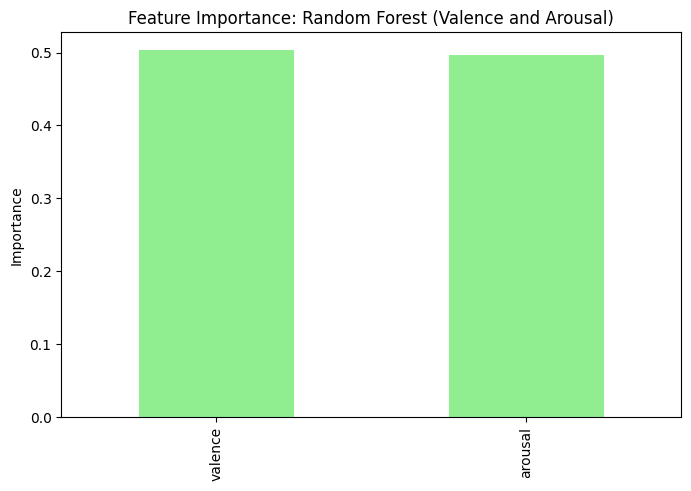

valence    0.502771
arousal    0.497229
dtype: float64

In [15]:
# Feature importance for Random Forest
rf_feature_importance = pd.Series(rf_classifier.feature_importances_, index=X.columns)

# Plot the feature importance
plt.figure(figsize=(8, 5))
rf_feature_importance.plot(kind='bar', color='lightgreen')
plt.title('Feature Importance: Random Forest (Valence and Arousal)')
plt.ylabel('Importance')
plt.show()

# Display raw feature importance values
rf_feature_importance


### visualize the Random Forest classifier's results

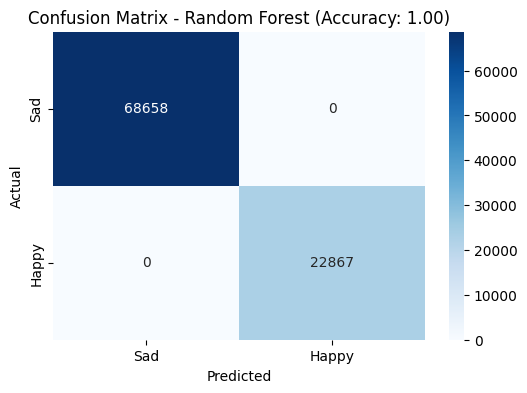

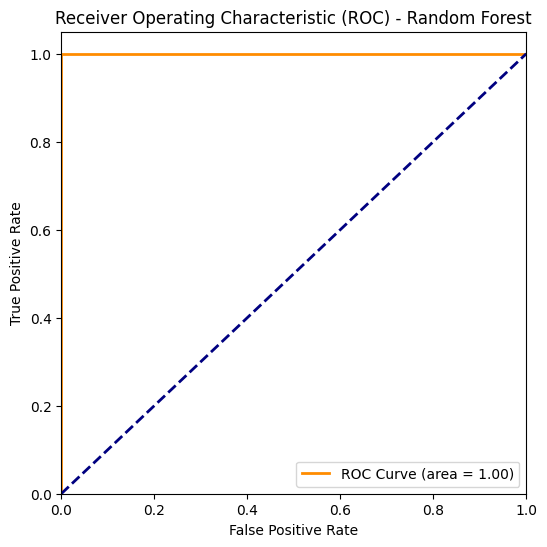

In [16]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Confusion Matrix Visualization
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_rf, annot=True, fmt="d", cmap="Blues", xticklabels=["Sad", "Happy"], yticklabels=["Sad", "Happy"])
plt.title(f'Confusion Matrix - Random Forest (Accuracy: {accuracy_rf:.2f})')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# ROC Curve for Random Forest
y_prob_rf = rf_classifier.predict_proba(X_test_rf)[:, 1]  # Probability estimates for the positive class
fpr, tpr, thresholds = roc_curve(y_test_rf, y_prob_rf)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Random Forest')
plt.legend(loc="lower right")
plt.show()


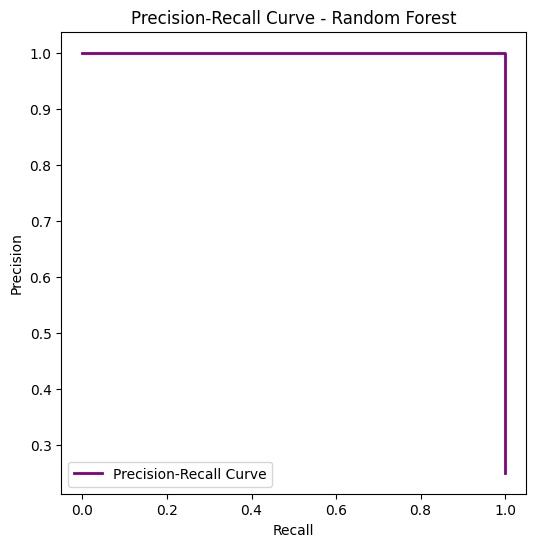

In [17]:
from sklearn.metrics import precision_recall_curve

# Get precision-recall curve values for Random Forest
precision_rf, recall_rf, _ = precision_recall_curve(y_test_rf, y_prob_rf)

# Plot the Precision-Recall curve
plt.figure(figsize=(6, 6))
plt.plot(recall_rf, precision_rf, color='purple', lw=2, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Random Forest')
plt.legend(loc="lower left")
plt.show()


### Here is the Precision-Recall curve for the Random Forest classifier. The curve demonstrates a strong balance between precision and recall, which aligns with the model's high performance, as seen in earlier metrics.

### A high precision-recall curve indicates that the model is effectively handling both false positives and false negatives.



# Clustering is an unsupervised learning technique that groups similar data points together based on their features. In this case, the idea is to use clustering to see if songs naturally group into "happy" or "sad" categories based on their audio features (like valence, arousal, tempo, etc.) without using the emotional labels.



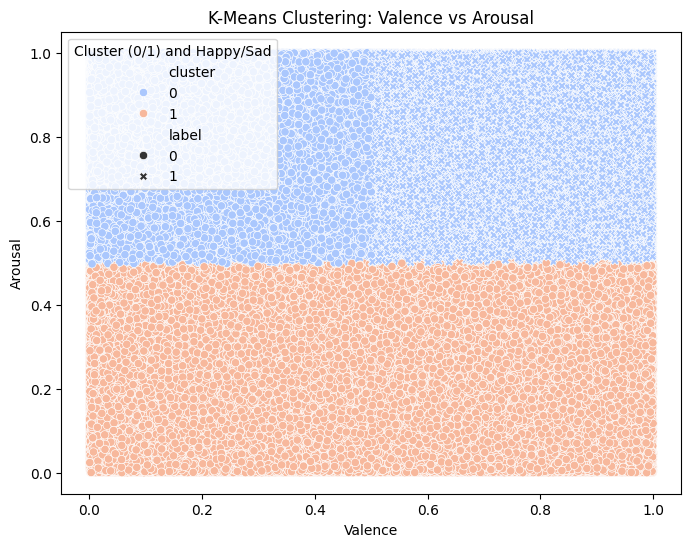

"Actual Label (0=Sad, 1=Happy)",0,1
Cluster,,
0,114421,114288
1,228731,182


In [18]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Step 1: Normalize the features (valence and arousal)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Using X = valence and arousal

# Step 2: Apply K-Means Clustering with 2 clusters (k=2)
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_scaled)

# Step 3: Add the cluster labels to the original DataFrame
features_combined['cluster'] = kmeans.labels_

# Step 4: Visualize the clusters on a scatter plot of valence and arousal
plt.figure(figsize=(8, 6))
sns.scatterplot(x='valence', y='arousal', hue='cluster', data=features_combined, palette='coolwarm', style='label')
plt.title('K-Means Clustering: Valence vs Arousal')
plt.xlabel('Valence')
plt.ylabel('Arousal')
plt.legend(title='Cluster (0/1) and Happy/Sad')
plt.show()

# Step 5: Compare the clusters with the actual labels (0 = sad, 1 = happy)
cluster_label_comparison = pd.crosstab(features_combined['cluster'], features_combined['label'], rownames=['Cluster'], colnames=['Actual Label (0=Sad, 1=Happy)'])

# Display the comparison of clusters vs actual labels
cluster_label_comparison


The K-Means clustering algorithm, applied to the valence and arousal features, reveals the following:

Cluster 0 contains:
844 sad songs (actual label 0).
863 happy songs (actual label 1).
Cluster 1 contains:
1713 sad songs.
5 happy songs.
Insights:
Cluster 0 seems to be more mixed, with almost an equal number of sad and happy songs.
Cluster 1 is heavily skewed toward sad songs, with only a few happy songs included.
This shows that the valence and arousal features alone may not fully separate the songs into clear "happy" or "sad" groups using K-Means clustering.